In [14]:
import sys
from netCDF4 import Dataset
import os
import cmocean as cm
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
from trackeddy.plotfunc import *
from numpy import *
from pylab import *
import cmocean as cm
%matplotlib inline
import scipy.optimize as opt

In [15]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def moveGaussian(size,fwhm,center,timestep):
    z=zeros([timestep,size,size])
    for tt in range(0,timestep):
        z[tt,:,:]=makeGaussian(size, fwhm, (center[tt,0],center[tt,1]))
    return z

[0.99335826443047615, -0.20408163265306101, 0.20408163265306101, 1, 1, 0, 0]
(50, 50)


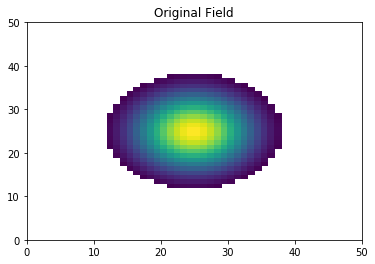

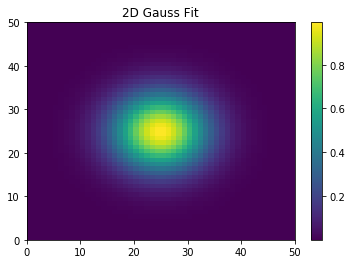

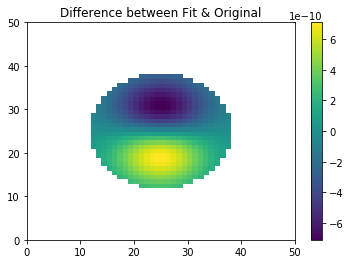

In [16]:
x,y=linspace(-10,10,50),linspace(-10,10,50)
X,Y=meshgrid(x,y)
gaussian=twoD_Gaussian((X,Y), 1, 0, 0, 2.5, 2.5, 0, 0)
zz=gaussian.reshape(50,50)
gausssianfitp=fit2Dgaussian(zz,x,y,0.1,initial_guess='',date='',diagnostics=True)


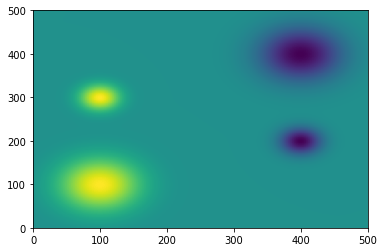

In [17]:
zz=moveGaussian(500,100,array([[x,x*0+100] for x in linspace(100,400,40)]),40)+\
    moveGaussian(500,50,array([[x,x*0+300] for x in linspace(100,400,40)]),40)-\
    moveGaussian(500,50,array([[500-x,x*0+200] for x in linspace(100,400,40)]),40)-\
    moveGaussian(500,100,array([[500-x,x*0+400] for x in linspace(100,400,40)]),40)
    
lat=linspace(0,50,500)
lon=linspace(0,50,500)
pcolormesh(zz[0,:,:])

In [18]:
eddytdp=analyseddyt(zz[:,:,:],lon,lat,0.2,0,40,1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)
eddytdn=analyseddyt(zz[:,:,:],lon,lat,-0.2,0,40,1,data_meant='',areamap='',mask=''\
                     ,destdir='',physics='',checkgauss=True,diagnostics=False,pprint=False)

 0% [=======================================>]100% Time Elapsed: 11 s  

In [19]:
def reconstruct_syntetic(var,eddytd):
    fieldfit=np.zeros(np.shape(var))
    for key in eddytd.keys():
        gaussfit=eddytd[key]['2dgaussianfit'][0]['gaussfit']
        for ii in range(0,len(eddytd[key]['2dgaussianfit'])):
            xindexpos=eddytd[key]['2dgaussianfit'][ii]['xindexpos']
            yindexpos=eddytd[key]['2dgaussianfit'][ii]['yindexpos']
            eddySfield=eddytd[key]['2dgaussianfit'][ii]['gaussfit']
            fieldfit[ii,yindexpos[0]:yindexpos[1],xindexpos[0]:xindexpos[1]]=eddySfield
    return fieldfit

In [20]:
fieldSp=reconstruct_syntetic(zz,eddytdp)
fieldSn=reconstruct_syntetic(zz,eddytdn)
fieldS=fieldSp+fieldSn

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

fig = plt.figure(figsize=(12, 4),facecolor='white')
gs = gridspec.GridSpec(1, 3)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(lon,lat,fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance)

ax2 = plt.subplot(gs[0,1])

quad2 = ax2.pcolormesh(lon,lat,zz[0,:,:],shading='gouraud',cmap=cm.cm.balance)
cb2 = fig.colorbar(quad2,ax=ax2)

ax3 = plt.subplot(gs[0,2])

quad3 = ax3.pcolormesh(lon,lat,zz[0,:,:]-fieldS[0,:,:],shading='gouraud',cmap=cm.cm.balance,vmin=-1,vmax=1)
cb3 = fig.colorbar(quad3,ax=ax3)


##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    quad2.set_array([])
    quad3.set_array([])
    return quad1,quad2,quad3
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(fieldS[iter,:,:].ravel())
    quad2.set_array(zz[iter,:,:].ravel())
    quad3.set_array(zz[iter,:,:].ravel()-fieldS[iter,:,:].ravel())
    return quad1,quad2,quad3
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=40,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2

In [24]:
# Output data path
outputpath='/g/data/v45/akm157/model_output/mom/mom01v5_kds75/output306/'
# Import SSH values to python environment.
ncfile=Dataset(outputpath+'rregionsouthern_ocean_daily_eta_t.nc')
eta=ncfile.variables['eta_t'][:]*100
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['xt_ocean_sub01'][:]
lat=ncfile.variables['yt_ocean_sub01'][:]

In [25]:
# Import SSH 10 yrs mean values to python environment.
ncfile=Dataset('/home/156/jm5970/notebooks/traceddy/data.input/meanssh_10yrs_AEXP.nc')
ssh_mean=squeeze(ncfile.variables['SSH_mean'][:])
# Import geographic coordinates (Lon,Lat)
lon=ncfile.variables['Longitude'][:]
lat=ncfile.variables['Latitude'][:]

In [26]:
areamap=array([[1000,1500],[500,900]])

In [27]:
# If you want to Analyse multiple levels, please go to the Moving in Z section.
eddytdp=analyseddyt(eta,lon,lat,level=10,t0=0,t1=30,tstep=1,data_meant=ssh_mean,\
                   areamap=areamap,mask='',destdir='',physics='',diagnostics=False,pprint=False)

 0% [=============================>]100% Time Elapsed: 16 s  

In [28]:
sfield=reconstruct_syntetic(eta,eddytdp)

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
############################
#Create the figure

fig = plt.figure(figsize=(12, 4),facecolor='white')
gs = gridspec.GridSpec(1, 3)

#############################

ax1 = plt.subplot(gs[0,0])

quad1 = ax1.pcolormesh(lon[1000:1500],lat[500:900],sfield[0,500:900,1000:1500],shading='gouraud',cmap=cm.cm.balance,vmin=-40,vmax=40)

ax2 = plt.subplot(gs[0,1])

quad2 = ax2.pcolormesh(lon[1000:1500],lat[500:900],eta[0,500:900,1000:1500]-ssh_mean[500:900,1000:1500],shading='gouraud',cmap=cm.cm.balance,vmin=-40,vmax=40)
cb2 = fig.colorbar(quad2,ax=ax2)

ax3 = plt.subplot(gs[0,2])

quad3 = ax3.pcolormesh(lon[1000:1500],lat[500:900],eta[0,500:900,1000:1500]-ssh_mean[500:900,1000:1500]-sfield[0,500:900,1000:1500],shading='gouraud',cmap=cm.cm.balance,vmin=-40,vmax=40)
cb3 = fig.colorbar(quad3,ax=ax3)


##############################

##############################
#Intitial stage blank
def init():
    quad1.set_array([])
    quad2.set_array([])
    quad3.set_array([])
    return quad1,quad2,quad3
##############################

##############################
#Animation function, replace the values of the eke in a '1d list'
def animate(iter):
    quad1.set_array(sfield[iter,500:900,1000:1500].ravel())
    quad2.set_array(eta[iter,500:900,1000:1500].ravel()-ssh_mean[500:900,1000:1500].ravel())
    quad3.set_array(eta[iter,500:900,1000:1500].ravel()-ssh_mean[500:900,1000:1500].ravel()-sfield[iter,500:900,1000:1500].ravel())
    return quad1,quad2,quad3
##############################

##############################
#Remove edges
gs.tight_layout(fig)
##############################

##############################
#Animation structure
anim2 = animation.FuncAnimation(fig,animate,frames=30,interval=1000,blit=False,repeat=True)
##############################
plt.close()
##############################
#Display and convert animation to html5
anim2